In [1]:
### Text Normalization/Cleansing
import re
import pandas as pd

#defination of data test, train, and validation
df = pd.read_csv("train_preprocess.txt", delimiter = "\t", header=None)

df.columns =['text', 'label']
sentiment = ['negative', 'neutral', 'positive']

#ChangeAlayPath
df_kbbi = pd.read_csv('KamusAlayIvan.csv', header=None, encoding='ISO-8859-1', names=['TIDAKBAKU', 'BAKU'])

C:\Users\ASUS iD\AppData\Local\Temp\ipykernel_1988\566574244.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df

,text,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative
...,...,...
10995,tidak kecewa,positive
10996,enak rasa masakan nya apalagi kepiting yang me...,positive
10997,hormati partai-partai yang telah berkoalisi,neutral
10998,"pagi pagi di tol pasteur sudah macet parah , b...",negative


In [3]:

#DefinitionCleansingFunction
def removechars(text):
    text = re.sub(r'[^\w]', ' ', text)
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))','',text)
    text = re.sub('\d', '', text)
    text = re.sub(r'\b\w\b', '', text)
###Stopwords in RemoveChars
    text = re.sub('di','',text)
    text = re.sub('yang','',text)
    text = re.sub('dan','',text)
    text = re.sub('nya','',text)
    text = re.sub('saya','',text)
    text = re.sub('ini','',text)
    text = re.sub('itu','',text)
    text = re.sub('aku','',text)
    text = re.sub('kamu','',text)
    text = re.sub('th','',text)
    return text

def changealay(text):
    alay = dict(zip(df_kbbi['TIDAKBAKU'], df_kbbi['BAKU']))
    text = ' '.join([alay[word] if word in alay else word for word in text.split(' ')])
    return text

In [4]:
import string

In [5]:
def cleaning(text):
    text = removechars(text)
    text = changealay(text)
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

In [6]:
df = pd.read_csv("/content/train_preprocess.tsv.txt", delimiter = "\t", header=None)
df.columns =['text', 'label']
sentiment = ['negative', 'neutral', 'positive']

df

FileNotFoundError: [Errno 2] No such file or directory: '/content/train_preprocess.tsv.txt'

In [7]:
df['text'] = df['text'].apply(cleaning)

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer()
tfidf_vect.fit(df['text'])

x = tfidf_vect.transform(df['text'])
print('Feature Extraction TFIDF Selesai')

Feature Extraction TFIDF Selesai


In [9]:
# Cek duplicate
df.duplicated().sum()
# Delete duplicate
df = df.drop_duplicates()
df.shape

(10931, 2)

In [10]:
df.label.value_counts()

label
positive    6382
negative    3412
neutral     1137
Name: count, dtype: int64

In [11]:
neg = df.loc[df['label'] == 'negative'].text.tolist()
neu = df.loc[df['label'] == 'neutral'].text.tolist()
pos = df.loc[df['label'] == 'positive'].text.tolist()

neg_label = df.loc[df['label'] == 'negative'].label.tolist()
neu_label = df.loc[df['label'] == 'neutral'].label.tolist()
pos_label = df.loc[df['label'] == 'positive'].label.tolist()

total_data = pos + neu + neg
labels = pos_label + neu_label + neg_label

print("Pos: %s, Neu: %s, Neg: %s" % (len(pos), len(neu), len(neg)))
print("Total data: %s" % len(total_data))

Pos: 6382, Neu: 1137, Neg: 3412
Total data: 10931


In [12]:
### Feature Extraction

import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict

max_features = 100000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(total_data)
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("tokenizer.pickle has created!")

X = tokenizer.texts_to_sequences(total_data)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

X = pad_sequences(X)
with open('x_pad_sequences.pickle', 'wb') as handle:
    pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("x_pad_sequences.pickle has created!")

tokenizer.pickle has created!
x_pad_sequences.pickle has created!


In [13]:
Y = pd.get_dummies(labels)
Y = Y.values

with open('y_labels.pickle', 'wb') as handle:
    pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("y_labels.pickle has created!")

y_labels.pickle has created!


In [14]:
### Prepare & Test Datasets/Splitting Dataset

from sklearn.model_selection import train_test_split

file = open("x_pad_sequences.pickle",'rb')
X = pickle.load(file)
file.close()

file = open("y_labels.pickle",'rb')
Y = pickle.load(file)
file.close()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

In [15]:
### Train

import numpy as np
from tensorflow.keras import Sequential, optimizers
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping

# Hyperparameters
max_features = 100000
embed_dim = 128
units = 256

# Membuat model
model = Sequential()
model.add(Embedding(input_dim=max_features, output_dim=embed_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.7))
model.add(LSTM(units=units, dropout=0.7, recurrent_dropout=0.7))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Menampilkan ringkasan model
print(model.summary())

# Callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# Melatih model
history = model.fit(X_train, y_train, epochs=10, batch_size=256, validation_data=(X_test, y_test), verbose=1, callbacks=[es])

# Evaluasi model
score = model.evaluate(X_test, y_test, verbose=0)
print(f"Test loss: {score[0]}, Test accuracy: {score[1]}")

c:\Users\ASUS iD\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │   0 (unbuilt) │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 350ms/step - accuracy: 0.5402 - loss: 1.0145 - val_accuracy: 0.6251 - val_loss: 0.7417
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 304ms/step - accuracy: 0.6438 - loss: 0.7616 - val_accuracy: 0.7549 - val_loss: 0.6070
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 301ms/step - accuracy: 0.7355 - loss: 0.6366 - val_accuracy: 0.7759 - val_loss: 0.5606
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 304ms/step - accuracy: 0.7773 - loss: 0.5652 - val_accuracy: 0.7997 - val_loss: 0.5141
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 312ms/step - accuracy: 0.7927 - loss: 0.5259 - val_accuracy: 0.8061 - val_loss: 0.4839
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 305ms/step - accuracy: 0.8071 - loss: 0.4820 - val_accuracy: 0.8455 - val_loss: 0.4496
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 300ms/step - accuracy: 0.8364 - loss: 0.4415 - val_accuracy: 0.8491 - val_loss: 0.4156
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 308ms/step - accuracy: 0.8521 - loss: 0.3954 - val

In [16]:
### Evaluation

from sklearn import metrics

predictions = model.predict(X_test)
y_pred = predictions
matrix_test = metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print("Testing selesai")
print(matrix_test)

69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step
Testing selesai
              precision    recall  f1-score   support

           0       0.79      0.83      0.81       670
           1       0.81      0.70      0.75       223
           2       0.91      0.91      0.91      1294

    accuracy                           0.86      2187
   macro avg       0.84      0.81      0.82      2187
weighted avg       0.87      0.86      0.86      2187



In [17]:
### Cross Validation

# Untuk lebih menyakinkan lagi, kita juga bisa melakukan "Cross Validation"
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

kf = KFold(n_splits=5,random_state=42,shuffle=True)

accuracies = []

y = Y

max_features = 100000
embed_dim = 128
units = 256
for iteration, data in enumerate(kf.split(X), start=1):

    data_train   = X[data[0]]
    target_train = y[data[0]]

    data_test    = X[data[1]]
    target_test  = y[data[1]]


    # Membuat model
    model = Sequential()
    model.add(Embedding(input_dim=max_features, output_dim=embed_dim, input_length=X.shape[1]))
    model.add(SpatialDropout1D(0.7))
    model.add(LSTM(units=units, dropout=0.7, recurrent_dropout=0.7))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Menampilkan ringkasan model
    print(model.summary())

    # Callbacks
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

    # Melatih model
    history = model.fit(X_train, y_train, epochs=10, batch_size=256, validation_data=(X_test, y_test), verbose=1, callbacks=[es])

    predictions = model.predict(X_test)
    y_pred = predictions

    # for the current fold only
    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

    print("Training ke-", iteration)
    print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print("======================================================")

    accuracies.append(accuracy)

# this is the average accuracy over all folds
average_accuracy = np.mean(accuracies)

print()
print()
print()
print("Rata-rata Accuracy: ", average_accuracy)

c:\Users\ASUS iD\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ ?                      │   0 (unbuilt) │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 14s 337ms/step - accuracy: 0.5349 - loss: 1.0157 - val_accuracy: 0.6356 - val_loss: 0.7436
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 304ms/step - accuracy: 0.6316 - loss: 0.7820 - val_accuracy: 0.7545 - val_loss: 0.6289
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 300ms/step - accuracy: 0.7337 - loss: 0.6543 - val_accuracy: 0.7732 - val_loss: 0.5629
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 300ms/step - accuracy: 0.7713 - loss: 0.5788 - val_accuracy: 0.7828 - val_loss: 0.5340
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 316ms/step - accuracy: 0.7858 - loss: 0.5331 - val_accuracy: 0.7929 - val_loss: 0.4936
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 303ms/step - accuracy: 0.8089 - loss: 0.4875 - val_accuracy: 0.8354 - val_loss: 0.4603
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 301ms/step - accuracy: 0.8228 - loss: 0.4507 - val_accuracy: 0.8564 - val_loss: 0.4331
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 302ms/step - accuracy: 0.8477 - loss: 0.4059 - val

c:\Users\ASUS iD\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_2             │ ?                      │   0 (unbuilt) │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 312ms/step - accuracy: 0.5310 - loss: 1.0098 - val_accuracy: 0.6626 - val_loss: 0.7277
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 302ms/step - accuracy: 0.6539 - loss: 0.7568 - val_accuracy: 0.7590 - val_loss: 0.6131
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 311ms/step - accuracy: 0.7391 - loss: 0.6453 - val_accuracy: 0.7755 - val_loss: 0.5525
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 306ms/step - accuracy: 0.7622 - loss: 0.5850 - val_accuracy: 0.7856 - val_loss: 0.5289
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 305ms/step - accuracy: 0.7936 - loss: 0.5164 - val_accuracy: 0.8171 - val_loss: 0.4734
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 299ms/step - accuracy: 0.8109 - loss: 0.4767 - val_accuracy: 0.8413 - val_loss: 0.4440
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 298ms/step - accuracy: 0.8420 - loss: 0.4286 - val_accuracy: 0.8528 - val_loss: 0.4090
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 308ms/step - accuracy: 0.8555 - loss: 0.3896 - val

c:\Users\ASUS iD\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_3             │ ?                      │   0 (unbuilt) │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 309ms/step - accuracy: 0.5308 - loss: 1.0129 - val_accuracy: 0.6539 - val_loss: 0.7405
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 304ms/step - accuracy: 0.6430 - loss: 0.7701 - val_accuracy: 0.7508 - val_loss: 0.6319
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 320ms/step - accuracy: 0.7415 - loss: 0.6467 - val_accuracy: 0.7741 - val_loss: 0.5552
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 314ms/step - accuracy: 0.7690 - loss: 0.5895 - val_accuracy: 0.7782 - val_loss: 0.5248
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 311ms/step - accuracy: 0.7870 - loss: 0.5299 - val_accuracy: 0.8189 - val_loss: 0.4837
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 307ms/step - accuracy: 0.8198 - loss: 0.4632 - val_accuracy: 0.8349 - val_loss: 0.4376
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 304ms/step - accuracy: 0.8300 - loss: 0.4356 - val_accuracy: 0.8555 - val_loss: 0.4271
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 311ms/step - accuracy: 0.8531 - loss: 0.4066 - val

c:\Users\ASUS iD\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_4             │ ?                      │   0 (unbuilt) │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 318ms/step - accuracy: 0.5305 - loss: 1.0140 - val_accuracy: 0.6086 - val_loss: 0.7758
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 310ms/step - accuracy: 0.6239 - loss: 0.7977 - val_accuracy: 0.7490 - val_loss: 0.6132
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 305ms/step - accuracy: 0.7414 - loss: 0.6519 - val_accuracy: 0.7737 - val_loss: 0.5677
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 302ms/step - accuracy: 0.7673 - loss: 0.5802 - val_accuracy: 0.7851 - val_loss: 0.5189
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 305ms/step - accuracy: 0.7899 - loss: 0.5219 - val_accuracy: 0.7974 - val_loss: 0.4869
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 302ms/step - accuracy: 0.7995 - loss: 0.4812 - val_accuracy: 0.8418 - val_loss: 0.4542
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 303ms/step - accuracy: 0.8303 - loss: 0.4426 - val_accuracy: 0.8551 - val_loss: 0.4175
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 310ms/step - accuracy: 0.8600 - loss: 0.3913 - val

c:\Users\ASUS iD\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_5             │ ?                      │   0 (unbuilt) │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 355ms/step - accuracy: 0.5342 - loss: 1.0210 - val_accuracy: 0.6004 - val_loss: 0.7641
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 359ms/step - accuracy: 0.6361 - loss: 0.7894 - val_accuracy: 0.7558 - val_loss: 0.6196
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 349ms/step - accuracy: 0.7387 - loss: 0.6579 - val_accuracy: 0.7764 - val_loss: 0.5534
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 379ms/step - accuracy: 0.7608 - loss: 0.5907 - val_accuracy: 0.7833 - val_loss: 0.5260
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 358ms/step - accuracy: 0.7804 - loss: 0.5362 - val_accuracy: 0.8006 - val_loss: 0.4817
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 341ms/step - accuracy: 0.8104 - loss: 0.4757 - val_accuracy: 0.8436 - val_loss: 0.4473
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 316ms/step - accuracy: 0.8277 - loss: 0.4480 - val_accuracy: 0.8427 - val_loss: 0.4131
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 318ms/step - accuracy: 0.8488 - loss: 0.3989 - val

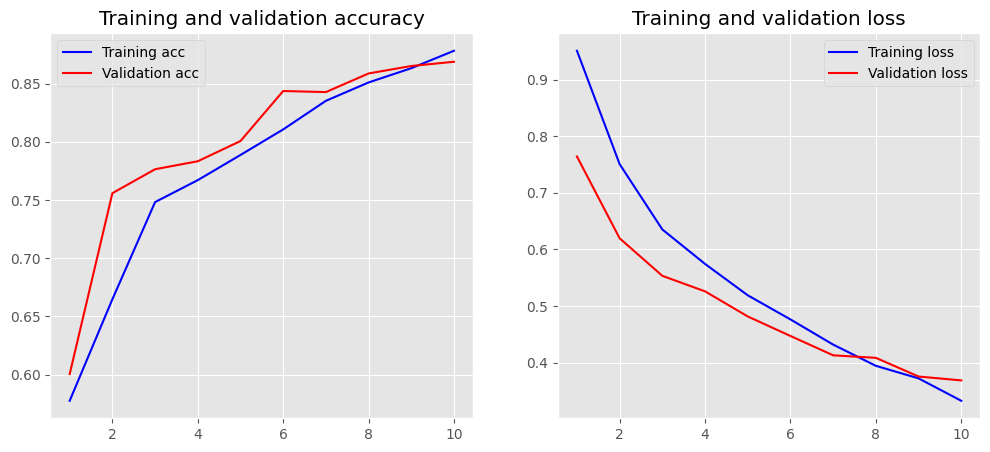

In [18]:
### Visualization
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

%matplotlib inline
plot_history(history)

In [19]:
model.save('model.h5')
print("Model has created!")

Model has created!


In [20]:
### Predict

import re
from keras.models import load_model

input_text = """
hormati partai-partai yang telah berkoalisi.
"""

def cleansing(sent):
    # Mengubah kata menjadi huruf kecil semua dengan menggunakan fungsi lower()
    string = sent.lower()
    # Menghapus emoticon dan tanda baca menggunakan "RegEx" dengan script di bawah
    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    return string

sentiment = ['negative', 'neutral', 'positive']

text = [cleansing(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])

print("Text: ",text[0])
print("Sentiment: ",sentiment[polarity])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
Text:   hormati partai partai yang telah berkoalisi  
Sentiment:  neutral


In [21]:
import re
from keras.models import load_model

input_text = """
sangat bagus sekali bro.
"""

def cleansing(sent):
    # Mengubah kata menjadi huruf kecil semua dengan menggunakan fungsi lower()
    string = sent.lower()
    # Menghapus emoticon dan tanda baca menggunakan "RegEx" dengan script di bawah
    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    return string

sentiment = ['negative', 'neutral', 'positive']

text = [cleansing(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])

print("Text: ",text[0])
print("Sentiment: ",sentiment[polarity])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
Text:   sangat bagus sekali bro  
Sentiment:  positive


In [ ]:
import re
from keras.models import load_model

input_text = """
jelek sekali sifat murid itu, dia selalu membuli temannya.
"""

def cleansing(sent):
    # Mengubah kata menjadi huruf kecil semua dengan menggunakan fungsi lower()
    string = sent.lower()
    # Menghapus emoticon dan tanda baca menggunakan "RegEx" dengan script di bawah
    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    return string

sentiment = ['negative', 'neutral', 'positive']

text = [cleansing(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])

print("Text: ",text[0])
print("Sentiment: ",sentiment[polarity])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
Text:   jelek sekali sifat murid itu  dia selalu membuli temannya  
Sentiment:  negative
